## Train FLAN T5 Model from Scratch for Question Answering Task for a given text input

__Index in the jupyter notebook__
1. Use a pre-trained google/flan-t5-small as the model.
2. Verify if the summarization task works.3. Verify if the Q&A task works.
4. Verify if English to French translation task works.
5. Programmatically print the names of all the model layers and their dimensions.
6. Programmatically print the total number of parameters/weights in this model.
7. Set the tensor in final layer (decoder.final_layer_norm.weight) to all zeros.
8. Verify if the Q&A task works after resetting the weights of the above layer.
9. Replace the decoder.final_layer_norm.weight with a layer of smaller dimensions and adjust all the dependent layers to match the dimension
10. Reload the original google/flan-t5-small model.
11. Train the model for a Q&A task that takes a context as additional input along with the question. You can use SQuAD dataset (https://rajpurkar.github.io/SQuAD-explorer/ ) or the smaller Topioca dataset (https://mcgill-nlp.github.io/topiocqa/) . Choose an appropriate task prefix/trigger word and justify the choice.
12. Evaluate the quality of the model



In [ ]:
%%bash
pip install nltk
pip install datasets
pip install transformers[torch]
pip install tokenizers
pip install evaluate
pip install rouge_score
pip install sentencepiece
pip install huggingface_hub

In [ ]:
# importing libraries
import nltk
import evaluate
import numpy as np
import torch.nn as nn
from datasets import load_dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq, AutoTokenizer, T5Config
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

## 1. Use a pre-trained google/flan-t5-small as the model.

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## 2. Verify if the summarization task works.

In [ ]:
sequence = ("Data science is an interdisciplinary field[10] focused on extracting knowledge from typically large data sets and applying the knowledge and insights from that data to solve problems in a wide range of application domains.[11] The field encompasses preparing data for analysis, formulating data science problems, analyzing data, developing data-driven solutions, and presenting findings to inform high-level decisions in a broad range of application domains. As such, it incorporates skills from computer science, statistics, information science, mathematics, data visualization, information visualization, data sonification, data integration, graphic design, complex systems, communication and business.[12][13] Statistician Nathan Yau, drawing on Ben Fry, also links data science to human–computer interaction: users should be able to intuitively control and explore data.[14][15] In 2015, the American Statistical Association identified database management, statistics and machine learning, and distributed and parallel systems as the three emerging foundational professional communities.[16]")

In [ ]:
sequence = ("ServiceNow, Inc. is an American software company based in Santa Clara, California, that develops a cloud computing platform to help companies manage digital workflows for enterprise operations. Founded in 2003 by Fred Luddy, ServiceNow is listed on the New York Stock Exchange and is a constituent of the Russell 1000 Index and S&P 500 Index.[2] In 2018, Forbes magazine named it number one on its list of the world's most innovative companies")

In [ ]:
inputs=tokenizer.encode("sumarize: " + sequence, return_tensors='pt', max_length=512, truncation=True)

In [ ]:
output = model.generate(inputs, min_length=50, max_length=80)
summary=tokenizer.decode(output[0])
print(summary)

<pad>Data science is a field of research and development that focuses on the development of data science and data science.[16][17][18][18][18][18][18][18][18][18][18][18][18][18][18][18][18][18][18


__Not Working Properly__

## 3. Verify if the Q&A task works.

In [ ]:
# Define context and question
q_and_a_context = "The Apollo program was a series of space missions undertaken by NASA designed to land humans on the Moon and bring them safely back to Earth. The first manned mission to the Moon was Apollo 11 in 1969. It was followed by six more successful missions, Apollo 12, 14, 15, 16, and 17, ending in 1972. Apollo 13 was intended to land, but an oxygen tank explosion forced the crew to return to Earth without landing."
question = "What was the first manned mission to the Moon?"

inputs = tokenizer.encode("question: " + question + " context: " + q_and_a_context, return_tensors="pt")

outputs = model.generate(inputs, max_length=50, num_return_sequences=1, early_stopping=True)
answer = tokenizer.decode(outputs[0])
print("Answer:", answer)

Answer: <pad> Apollo 11</s>


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


__WORKING with a proper context__

## 4. Verify if English to French translation task works.

In [ ]:
input_text = "translate English to French: How old are you?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


__Not Working.__ Tried with German that worked.

## 5. Programmatically print the names of all the model layers and their dimensions.

In [ ]:
# Print names and dimensions of all model layers
for name, param in model.named_parameters():
    print('name: ', name, 'shape: ', param.shape)

name:  shared.weight shape:  torch.Size([32128, 512])
name:  encoder.block.0.layer.0.SelfAttention.q.weight shape:  torch.Size([384, 512])
name:  encoder.block.0.layer.0.SelfAttention.k.weight shape:  torch.Size([384, 512])
name:  encoder.block.0.layer.0.SelfAttention.v.weight shape:  torch.Size([384, 512])
name:  encoder.block.0.layer.0.SelfAttention.o.weight shape:  torch.Size([512, 384])
name:  encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight shape:  torch.Size([32, 6])
name:  encoder.block.0.layer.0.layer_norm.weight shape:  torch.Size([512])
name:  encoder.block.0.layer.1.DenseReluDense.wi_0.weight shape:  torch.Size([1024, 512])
name:  encoder.block.0.layer.1.DenseReluDense.wi_1.weight shape:  torch.Size([1024, 512])
name:  encoder.block.0.layer.1.DenseReluDense.wo.weight shape:  torch.Size([512, 1024])
name:  encoder.block.0.layer.1.layer_norm.weight shape:  torch.Size([512])
name:  encoder.block.1.layer.0.SelfAttention.q.weight shape:  torch.Size([384, 512])

## 6. Programmatically print the total number of parameters/weights in this model.

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 76961152


## 7. Set the tensor in final layer (decoder.final_layer_norm.weight) to all zeros.

In [ ]:
# Set final layer weights to zeros
model.decoder.final_layer_norm.weight.data.fill_(0.0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## 8. Verify if the Q&A task works after resetting the weights of the above layer.

In [ ]:
q_and_ainputs = tokenizer.encode("question: " + question + " context: " + q_and_a_context, return_tensors="pt")
q_and_a_outputs = model.generate(inputs, max_length=50, num_return_sequences=1, early_stopping=True)
answer = tokenizer.decode(outputs[0])

print("Answer after resetting weights:", answer)

Answer after resetting weights: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


__Not Getting Any Response__

## 9. Replace the decoder.final_layer_norm.weight with a layer of smaller dimensions and adjust all the dependent layers to match the dimension

In [ ]:
# Load the pre-trained model configuration
config = T5Config.from_pretrained("google/flan-t5-small")

# Define new dimensions for the final layer norm
new_final_layer_norm_dim = 128  # tuning

config.d_model = new_final_layer_norm_dim # Modify the configuration to reflect the changes
new_model = T5ForConditionalGeneration(config=config)

# Replace the final layer norm with a layer of smaller dimensions
new_model.decoder.final_layer_norm = nn.LayerNorm(new_final_layer_norm_dim)

# Adjust all dependent layers to match the new dimension
# For simplicity, let's assume only the output projection layer is dependent and adjust it
new_model.get_output_embeddings().weight = nn.Parameter(
    new_model.get_output_embeddings().weight[:, :new_final_layer_norm_dim]
)

In [ ]:
q_and_ainputs = tokenizer.encode("question: " + question + " context: " + q_and_a_context, return_tensors="pt")
q_and_a_outputs = new_model.generate(inputs, max_length=50, num_return_sequences=1)
answer = tokenizer.decode(outputs[0])

print("Answer after resetting weights:", answer)

Answer after resetting weights: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


__Not getting any response__

## 10. Reload the original google/flan-t5-small model.

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 11. Train the model for a Q&A task that takes a context as additional input along with the ..
question. You can use SQuAD dataset (https://rajpurkar.github.io/SQuAD-explorer/ )
or the smaller Topioca dataset (https://mcgill-nlp.github.io/topiocqa/) . Choose an
appropriate task prefix/trigger word and justify the choice.

https://rajpurkar.github.io/SQuAD-explorer/#:~:text=might%20be%20unanswerable.-,SQuAD2.,the%20100%2C000%20questions%20in%20SQuAD1.&text=0%2C%20systems%20must%20not%20only,paragraph%20and%20abstain%20from%20answering.&text=SQuAD%201.1%2C%20the%20previous%20version,answer%20pairs%20on%20500%2B%20articles.

In [ ]:
dataset = load_dataset("squad")#squad_v2

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
dataset["train"][6]

{'id': '5733bf84d058e614000b61bf',
 'title': 'University_of_Notre_Dame',
 'context': "As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, 

taking the validation part for due to limited resource available

In [ ]:
squad_qa = dataset["validation"].train_test_split(test_size=0.3)# take the train part and train with it

### Preprocess

In [ ]:
# We prefix our tasks with "answer the question"
prefix = "Answer the qs: "

# Define the preprocessing function

def preprocess_function(examples):
   """Add prefix to the sentences, tokenize the text, and set the labels"""
   # The "inputs" are the tokenized answer:
   inputs = []
   for i in range(len(examples["question"])):
        inputs.append(prefix + examples["question"][i] + 'Given context: ' + examples["context"][i])
   #inputs = [prefix + doc  + for doc in examples["question"]]
   model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
   model_output = [doc["text"][0] for doc in examples["answers"]]
   #print(examples["answers"])
   #answers = examples["answers"]["text"][0]
   #print(answers)
   # The "labels" are the tokenized outputs:
   labels = tokenizer(text_target=model_output,
                      max_length=248,
                      truncation=True)

   model_inputs["labels"] = labels["input_ids"]
   return model_inputs

In [ ]:
# Map the preprocessing function across our dataset
tokenized_dataset = squad_qa.map(preprocess_function, batched=True)

Map:   0%|          | 0/7399 [00:00<?, ? examples/s]

Map:   0%|          | 0/3171 [00:00<?, ? examples/s]

In [ ]:
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

In [ ]:
def compute_metrics(eval_preds):
   preds, labels = eval_preds

   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

   result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

   return result

## Model Training

In [ ]:
# Global Parameters
L_RATE = 3e-4
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 4
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 4

In [ ]:
#from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

In [ ]:
# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False
)

In [ ]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.583500,0.481565,0.746599,0.479322,0.746051,0.746312
2,0.445000,0.496622,0.747429,0.472507,0.747172,0.747430
3,0.308200,0.512347,0.757324,0.479703,0.757723,0.757696


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.583500,0.481565,0.746599,0.479322,0.746051,0.746312
2,0.445000,0.496622,0.747429,0.472507,0.747172,0.747430
3,0.308200,0.512347,0.757324,0.479703,0.757723,0.757696
4,0.225500,0.547093,0.763898,0.490283,0.763500,0.763860


TrainOutput(global_step=3700, training_loss=0.39542021674078864, metrics={'train_runtime': 1502.7839, 'train_samples_per_second': 19.694, 'train_steps_per_second': 2.462, 'total_flos': 3628742401474560.0, 'train_loss': 0.39542021674078864, 'epoch': 4.0})

## 12. Evaluate the quality of the model

__Rouge Metrics (Rouge1, Rouge2, Rougel, and Rougelsum):__ Higher values in these metrics are preferable as they indicate better text q&A performance. Across all four Rouge metrics, the values have increased over the epochs, with the highest values recorded in epoch 4

__Training Loss and Validation Loss:__ Lower values in these metrics are preferable as they indicate a better fit of the model to the data. The training and validation loss has decreased over the epochs, with the lowest values recorded in epoch 4.

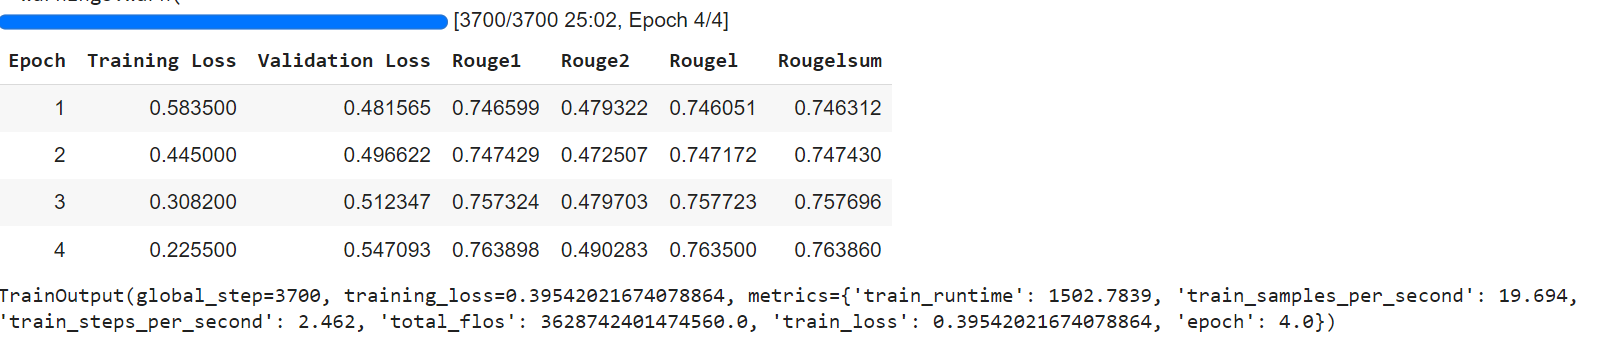

## Model Inference

In [40]:
import glob

In [42]:
filelist = glob.glob('./results/*', recursive = True)

In [43]:
filelist

['./results/checkpoint-2500',
 './results/checkpoint-3500',
 './results/runs',
 './results/checkpoint-3000']

In [44]:
last_checkpoint = "./results/checkpoint-3500"

finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(last_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


__I have taken the squad validation set for training. Now let us use some sample from training set for inferencing__

In [47]:
dataset["train"][2]

{'id': '5733be284776f41900661180',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?',
 'answers': {'text': ['the Main Building'], 'answer_start': [279]}}

In [51]:
prefix = "Answer the qs: "
context= """Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858."""
question= "The Basilica of the Sacred heart at Notre Dame is beside to which structure?"
inference_input = prefix + question + 'Given context: ' + context

In [53]:
inputs = tokenizer(inference_input, return_tensors="pt")
outputs = finetuned_model.generate(**inputs)
answer = tokenizer.decode(outputs[0])
from textwrap import fill

print(fill(answer, width=80))

<pad> Main Building</s>


__Working__

In [56]:
#Lets take another sample
dataset["train"][200]

{'id': '5733849bd058e614000b5c56',
 'title': 'University_of_Notre_Dame',
 'context': "In 1842, the Bishop of Vincennes, Célestine Guynemer de la Hailandière, offered land to Father Edward Sorin of the Congregation of the Holy Cross, on the condition that he build a college in two years. Fr. Sorin arrived on the site with eight Holy Cross brothers from France and Ireland on November 26, 1842, and began the school using Father Stephen Badin's old log chapel. He soon erected additional buildings, including Old College, the first church, and the first main building. They immediately acquired two students and set about building additions to the campus.",
 'question': 'In what year was Father Edward Sorin given two years to create a college?',
 'answers': {'text': ['1842'], 'answer_start': [3]}}

In [57]:
prefix = "Answer the qs: "
context= """In 1842, the Bishop of Vincennes, Célestine Guynemer de la Hailandière, offered land to Father Edward Sorin of the Congregation of the Holy Cross, on the condition that he build a college in two years. Fr. Sorin arrived on the site with eight Holy Cross brothers from France and Ireland on November 26, 1842, and began the school using Father Stephen Badin's old log chapel. He soon erected additional buildings, including Old College, the first church, and the first main building."""
question= "In what year was Father Edward Sorin given two years to create a college?"
inference_input = prefix + question + 'Given context: ' + context

In [58]:
inputs = tokenizer(inference_input, return_tensors="pt")
outputs = finetuned_model.generate(**inputs)
answer = tokenizer.decode(outputs[0])
from textwrap import fill

print(fill(answer, width=80))

<pad> 1842</s>


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


__Working__

So far this has worked.

__Limitation__: Flan-T5 has not been tested in real world applications.

### Future Task


* Train on traing data on squad dataset. Use version 2 as well
* Data preprocessing
* Hyperparameter tuning
* Train same model over different task

In [55]:
#END